## 策略逻辑：
60分钟看长短期MA趋势， 15分钟做均线择时。

In [85]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiSigStrategy(CtaTemplate):
    className = 'MultiSigMaStrategy'
    author = 'xiaotao'
    
    # 策略参数
    fastPeriod = 33; slowPeriod = 55
    signalMaPeriod = 20
    
    fastPeriod_v = 2    #成交量快速均线参数
    slowPeriod_v = 4    #成交量慢速均线参数
    
    
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod', 'slowPeriod','fastPeriod_v','slowPeriod_v','signalMaPeriod'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        pass
    
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        diff_fastMa = (fastMa[-1]-fastMa[-2])/fastMa[-1]
        
        fastMa_v = ta.EMA(am60.volume, self.fastPeriod_v)
        slowMa_v = ta.EMA(am60.volume, self.slowPeriod_v)
        diff_fastMa_v = (fastMa_v[-1]-fastMa_v[-2])/fastMa_v[-1]
        
        
        if (fastMa[-1] > slowMa[-1]) and (fastMa_v[-1]>slowMa_v[-1]) and (fastMa_v[-2]>slowMa_v[-2]) and (diff_fastMa_v>0) and (diff_fastMa>0):
            self.maTrend[symbol] = 1
        elif (fastMa[-1] <= slowMa[-1]) and (fastMa_v[-1]<slowMa_v[-1]) and (fastMa_v[-2]<slowMa_v[-2]) and (diff_fastMa_v<0) and (diff_fastMa<0):
            self.maTrend[symbol] = -1
        else:
            self.maTrend[symbol] = 0
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        signalMa = ta.EMA(am15.close, self.signalMaPeriod)

        maUp = signalMa[-1]>signalMa[-4] # 均线上涨
        maDn = signalMa[-1]<signalMa[-4] # 均线下跌
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if maUp and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if maDn and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
#                 self.cancelAll() # 撤销挂单
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做交易信息记录的策略，可以忽略onTrade
        pass
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 配置引擎回测

In [86]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy import BacktestingEngine

    # 创建回测引擎对象
    engine = BacktestingEngine()

    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
    engine.setStartDate('20180601 12:00',initHours=200) # 设置回测用的数据起始日期
    engine.setEndDate('20181127 12:00') # 设置回测用的数据终止日期

    # 配置回测引擎参数
    engine.setSlippage(0.002)    # 设置滑点
    engine.setRate(5/10000)   # 设置手续费千1
    engine.setCapital(1000000)  # 设置回测本金

    # # 在引擎中创建策略对象
    parameterDict = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置
    engine.initStrategy(MultiSigMaStrategy, parameterDict)    # 创建策略对象
    engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x0000019414FF4AE8>, <__main__.MultiFrameMaStrategy object at 0x00000194131C6DA0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x0000019414FF4BF8>, <__main__.MultiFrameMaStrategy object at 0x00000194131C6DA0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x0000019414FF4B70>, <__main__.MultiFrameMaStrategy object at 0x00000194131C6DA0>)
2018-12-21 07:58:35.972547	开始回测
2018-12-21 07:58:35.972547	策略初始化
2018-12-21 07:58:35.974530	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-21 07:58:36.504132	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-21 07:58:36.507155	载入完成，数据量：12000
2018-12-21 07:58:36.507155	策略初始化完成
2018-12-21 07:58:36.507155	策略启动完成
2018-12-21 07:58:36.507155	开始回放回测数据,回测范围:[20180601 12:00,20

In [87]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-11-09 06:15:00,空,,,0.0,,开仓,95,,6504.98,0.0,None,,,95,2018-11-09 06:15:00,1,95,BTCUSDT:binance,95
2018-11-13 11:15:00,多,,,0.0,,平仓,96,,6463.03,0.0,None,,,96,2018-11-13 11:15:00,1,96,BTCUSDT:binance,96
2018-11-13 11:15:00,多,,,0.0,,开仓,97,,6463.03,0.0,None,,,97,2018-11-13 11:15:00,1,97,BTCUSDT:binance,97
2018-11-14 22:00:00,空,,,0.0,,平仓,98,,6363.40,0.0,None,,,98,2018-11-14 22:00:00,1,98,BTCUSDT:binance,98
2018-11-14 22:00:00,空,,,0.0,,开仓,99,,6363.40,0.0,None,,,99,2018-11-14 22:00:00,1,99,BTCUSDT:binance,99


## 查看绩效与优化

2018-12-21 07:59:09.685353	计算按日统计结果
2018-12-21 07:59:09.731265	------------------------------
2018-12-21 07:59:09.731265	首个交易日：	2018-06-01 00:00:00
2018-12-21 07:59:09.731265	最后交易日：	2018-11-27 00:00:00
2018-12-21 07:59:09.731265	总交易日：	180
2018-12-21 07:59:09.731265	盈利交易日	103
2018-12-21 07:59:09.732228	亏损交易日：	76
2018-12-21 07:59:09.732228	起始资金：	1000000
2018-12-21 07:59:09.732228	结束资金：	1,006,699.15
2018-12-21 07:59:09.732228	总收益率：	0.67%
2018-12-21 07:59:09.732228	年化收益：	0.89%
2018-12-21 07:59:09.732228	总盈亏：	6,699.15
2018-12-21 07:59:09.732228	最大回撤: 	-2,064.28
2018-12-21 07:59:09.732228	百分比最大回撤: -0.21%
2018-12-21 07:59:09.732228	总手续费：	335.09
2018-12-21 07:59:09.732228	总滑点：	0.2
2018-12-21 07:59:09.732228	总成交金额：	670,175.75
2018-12-21 07:59:09.732228	总成交笔数：	99
2018-12-21 07:59:09.732228	日均盈亏：	37.22
2018-12-21 07:59:09.732228	日均手续费：	1.86
2018-12-21 07:59:09.732228	日均滑点：	0.0
2018-12-21 07:59:09.732228	日均成交金额：	3,723.2
2018-12-21 07:59:09.732228	日均成交笔数：	0.55
2018-12-21 07:59:09.733226	日均收益率：	0.0%

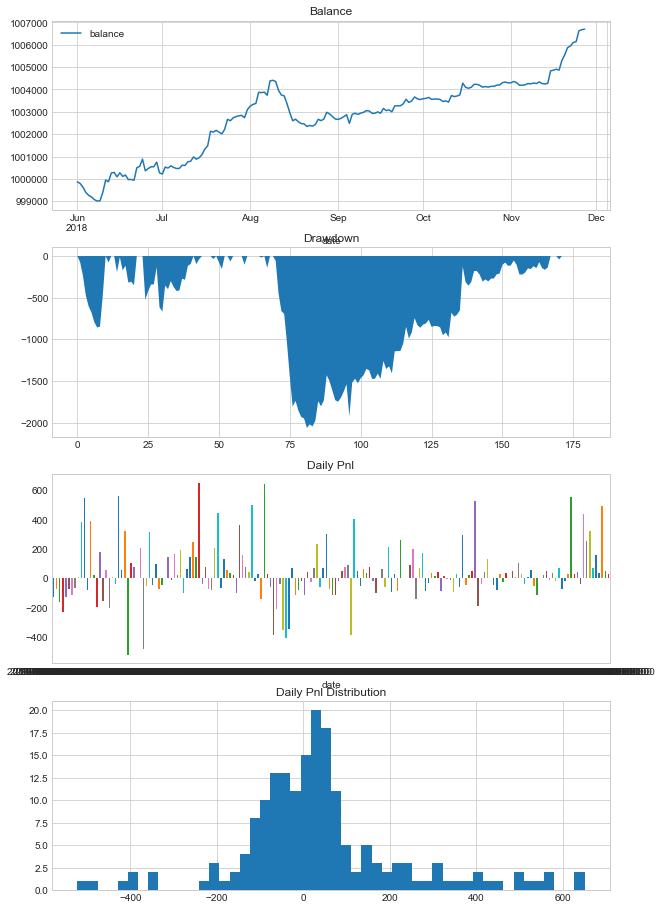

In [88]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-21 07:59:13.057815	计算回测结果
2018-12-21 07:59:13.065819	------------------------------
2018-12-21 07:59:13.066817	第一笔交易：	2018-06-02 14:45:00
2018-12-21 07:59:13.066817	最后一笔交易：	2018-11-27 11:58:00
2018-12-21 07:59:13.066817	总交易次数：	50
2018-12-21 07:59:13.066817	总盈亏：	6,697.25
2018-12-21 07:59:13.066817	最大回撤: 	-1,975.16
2018-12-21 07:59:13.066817	平均每笔盈利：	133.94
2018-12-21 07:59:13.066817	平均每笔滑点：	0.0
2018-12-21 07:59:13.066817	平均每笔佣金：	6.74
2018-12-21 07:59:13.066817	胜率		48.0%
2018-12-21 07:59:13.066817	盈利交易平均值	447.39
2018-12-21 07:59:13.066817	亏损交易平均值	-155.39
2018-12-21 07:59:13.066817	盈亏比：	2.88


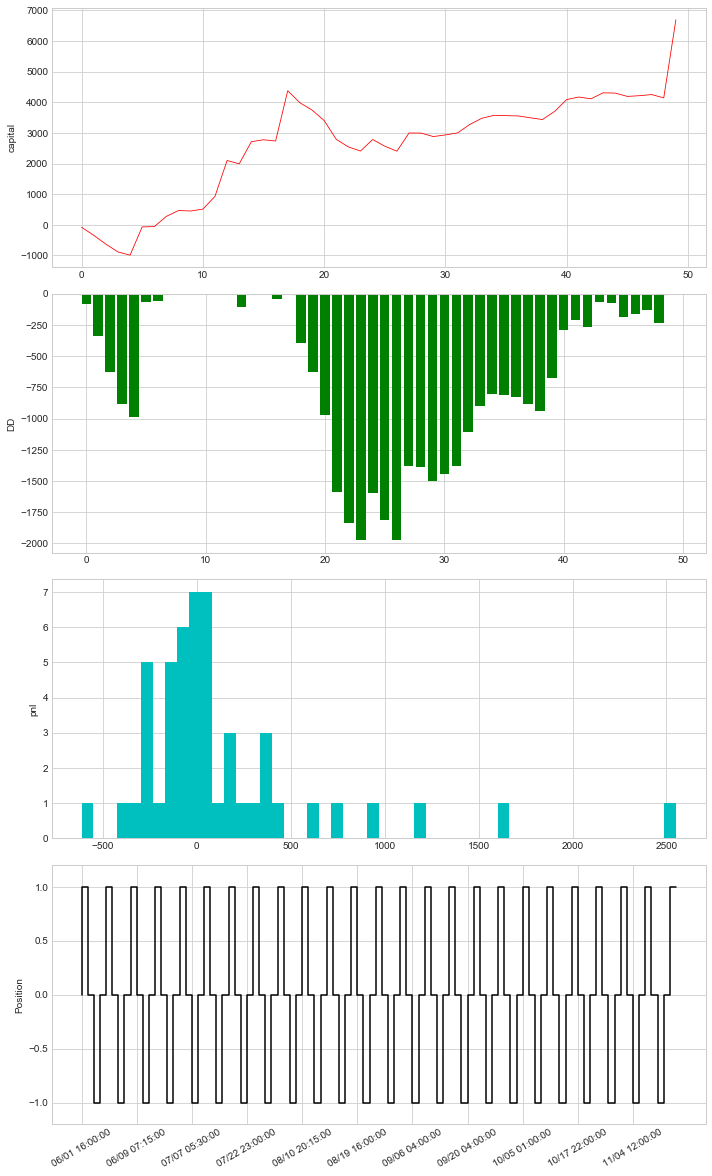

In [89]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [90]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)
print(pd.Series(result))

2018-12-21 07:59:15.070652	计算按日统计结果
startDate           2018-06-01 00:00:00
endDate             2018-11-27 00:00:00
totalDays                           180
profitDays                          103
lossDays                             76
endBalance                   1.0067e+06
maxDrawdown                    -2064.28
maxDdPercent                  -0.205521
totalNetPnl                     6699.15
dailyNetPnl                     37.2175
totalCommission                 335.088
dailyCommission                  1.8616
totalSlippage                     0.198
dailySlippage                    0.0011
totalTurnover                    670176
dailyTurnover                    3723.2
totalTradeCount                      99
dailyTradeCount                    0.55
totalReturn                    0.669915
annualizedReturn               0.893221
dailyReturn                  0.00378078
returnStd                      0.018883
sharpeRatio                     3.10182
dtype: object


In [100]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiSigStrategy(CtaTemplate):
    className = 'MultiSigStrategy'
    author = 'xiaotao'
    
    # 策略参数
    fastPeriod = 33; slowPeriod = 55
    signalMaPeriod = 3
    
    fastPeriod_v = 10    #成交量快速均线参数
    slowPeriod_v = 15    #成交量慢速均线参数
    
    
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod', 'slowPeriod',
                 'signalMaPeriod'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        pass
    
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        diff_fastMa = (fastMa[-1]-fastMa[-2])/fastMa[-1]
        
        fastMa_v = ta.EMA(am60.volume, self.fastPeriod_v)
        slowMa_v = ta.EMA(am60.volume, self.slowPeriod_v)
        diff_fastMa_v = (fastMa_v[-1]-fastMa_v[-2])/fastMa_v[-1]
        
        
        if (fastMa[-1] > slowMa[-1]) and (fastMa_v[-1]>slowMa_v[-1]) and (fastMa_v[-2]>slowMa_v[-2]) and (diff_fastMa_v>0) and (diff_fastMa>0):
            self.maTrend[symbol] = 1
        elif (fastMa[-1] <= slowMa[-1]) and (fastMa_v[-1]<slowMa_v[-1]) and (fastMa_v[-2]<slowMa_v[-2]) and (diff_fastMa_v<0) and (diff_fastMa<0):
            self.maTrend[symbol] = -1
        else:
            self.maTrend[symbol] = 0
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        signalMa = ta.EMA(am15.close, self.signalMaPeriod)

        maUp = signalMa[-1]>signalMa[-4] # 均线上涨
        maDn = signalMa[-1]<signalMa[-4] # 均线下跌
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if maUp and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if maDn and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
#                 self.cancelAll() # 撤销挂单
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做交易信息记录的策略，可以忽略onTrade
        pass
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [101]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy import BacktestingEngine

    # 创建回测引擎对象
    engine = BacktestingEngine()

    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
    engine.setStartDate('20180610 12:00',initHours=200) # 设置回测用的数据起始日期
    engine.setEndDate('20181127 12:00') # 设置回测用的数据终止日期

    # 配置回测引擎参数
    engine.setSlippage(0.002)    # 设置滑点
    engine.setRate(5/10000)   # 设置手续费千1
    engine.setCapital(1000000)  # 设置回测本金

    # # 在引擎中创建策略对象
    parameterDict = {'symbolList':['EOSUSDT:binance']}          # 策略参数配置
    engine.initStrategy(MultiSigStrategy, parameterDict)    # 创建策略对象
    engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x0000019414CC5730>, <__main__.MultiFrameMaStrategy object at 0x000001941226ED68>)
[DEBUG] 注册品种EOSUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x0000019414CC5EA0>, <__main__.MultiFrameMaStrategy object at 0x000001941226ED68>)
[DEBUG] 注册品种EOSUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x0000019414CC5D90>, <__main__.MultiFrameMaStrategy object at 0x000001941226ED68>)
2018-12-21 13:00:44.437886	开始回测
2018-12-21 13:00:44.437886	策略初始化
2018-12-21 13:00:44.439878	载入历史数据。数据范围:[20180602 04:00,20180610 12:00)
2018-12-21 13:00:45.419261	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-21 13:00:45.423248	载入完成，数据量：12000
2018-12-21 13:00:45.423248	策略初始化完成
2018-12-21 13:00:45.423248	策略启动完成
2018-12-21 13:00:45.423248	开始回放回测数据,回测范围:[20180610 12:00,20

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

In [102]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-11-15 09:30:00,空,,,0.0,,开仓,109,,4.7672,0.0,None,,,109,2018-11-15 09:30:00,1,109,EOSUSDT:binance,109
2018-11-22 23:00:00,多,,,0.0,,平仓,110,,3.7590,0.0,None,,,110,2018-11-22 23:00:00,1,110,EOSUSDT:binance,110
2018-11-22 23:00:00,多,,,0.0,,开仓,111,,3.7590,0.0,None,,,111,2018-11-22 23:00:00,1,111,EOSUSDT:binance,111
2018-11-23 03:00:00,空,,,0.0,,平仓,112,,3.7529,0.0,None,,,112,2018-11-23 03:00:00,1,112,EOSUSDT:binance,112
2018-11-23 03:00:00,空,,,0.0,,开仓,113,,3.7529,0.0,None,,,113,2018-11-23 03:00:00,1,113,EOSUSDT:binance,113


2018-12-21 13:01:17.788017	计算按日统计结果
2018-12-21 13:01:17.827911	------------------------------
2018-12-21 13:01:17.827911	首个交易日：	2018-06-10 00:00:00
2018-12-21 13:01:17.827911	最后交易日：	2018-11-27 00:00:00
2018-12-21 13:01:17.827911	总交易日：	171
2018-12-21 13:01:17.827911	盈利交易日	86
2018-12-21 13:01:17.827911	亏损交易日：	84
2018-12-21 13:01:17.827911	起始资金：	1000000
2018-12-21 13:01:17.827911	结束资金：	1,000,003.16
2018-12-21 13:01:17.827911	总收益率：	0.0%
2018-12-21 13:01:17.827911	年化收益：	0.0%
2018-12-21 13:01:17.827911	总盈亏：	3.16
2018-12-21 13:01:17.827911	最大回撤: 	-2.9
2018-12-21 13:01:17.827911	百分比最大回撤: -0.0%
2018-12-21 13:01:17.827911	总手续费：	0.36
2018-12-21 13:01:17.827911	总滑点：	0.23
2018-12-21 13:01:17.827911	总成交金额：	722.88
2018-12-21 13:01:17.827911	总成交笔数：	113
2018-12-21 13:01:17.829914	日均盈亏：	0.02
2018-12-21 13:01:17.829914	日均手续费：	0.0
2018-12-21 13:01:17.829914	日均滑点：	0.0
2018-12-21 13:01:17.829914	日均成交金额：	4.23
2018-12-21 13:01:17.829914	日均成交笔数：	0.66
2018-12-21 13:01:17.829914	日均收益率：	0.0%
2018-12-21 13:01:17.8

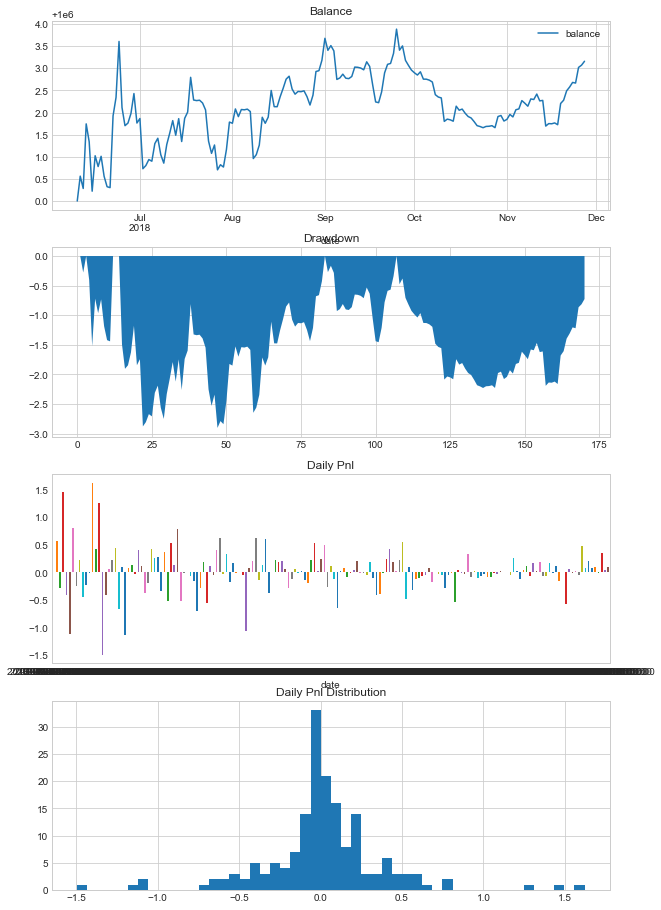

In [104]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-21 07:59:55.144926	计算回测结果
2018-12-21 07:59:55.154899	------------------------------
2018-12-21 07:59:55.158889	第一笔交易：	2018-06-16 03:00:00
2018-12-21 07:59:55.158889	最后一笔交易：	2018-11-27 11:58:00
2018-12-21 07:59:55.159885	总交易次数：	55
2018-12-21 07:59:55.159885	总盈亏：	6.5
2018-12-21 07:59:55.159885	最大回撤: 	-1.7
2018-12-21 07:59:55.159885	平均每笔盈利：	0.12
2018-12-21 07:59:55.159885	平均每笔滑点：	0.0
2018-12-21 07:59:55.159885	平均每笔佣金：	0.01
2018-12-21 07:59:55.159885	胜率		45.45%
2018-12-21 07:59:55.159885	盈利交易平均值	0.62
2018-12-21 07:59:55.159885	亏损交易平均值	-0.3
2018-12-21 07:59:55.159885	盈亏比：	2.08


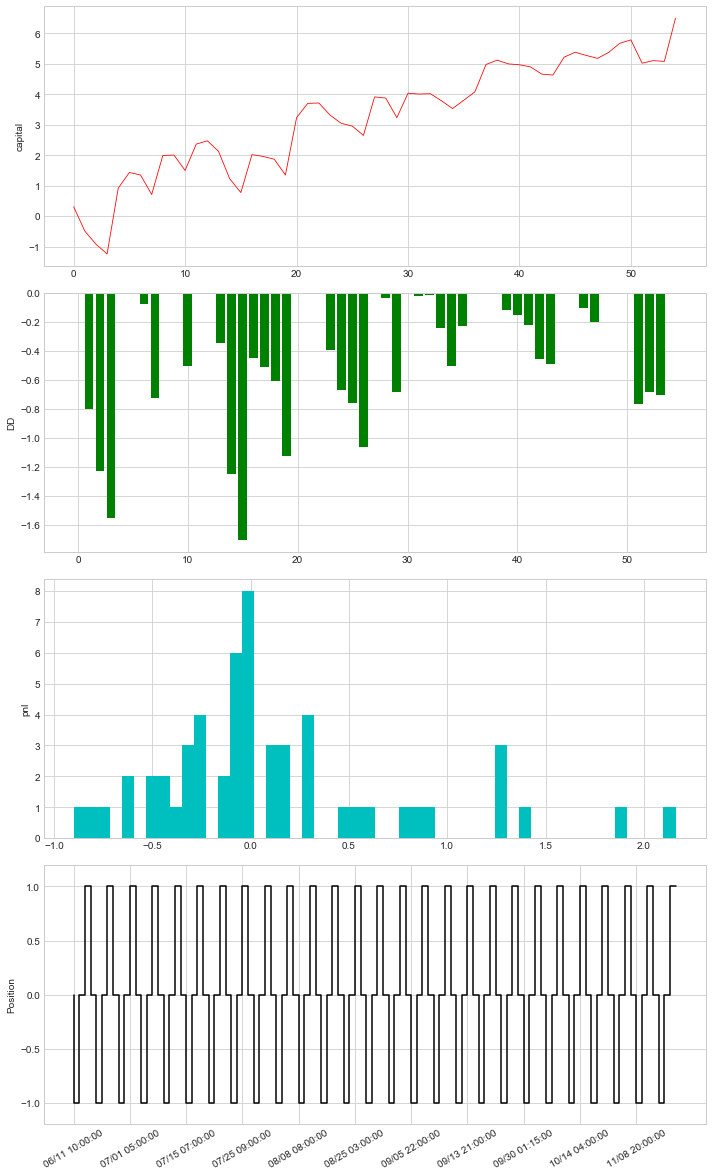

In [95]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [99]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('fastPeriod_v', 10, 30, 5)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('slowPeriod_v', 10, 40, 5)    # 增加第二个优化参数，起始60，结束30，步进10
setting.addParameter('signalMaPeriod', 2, 14, 1)    # 增加第二个优化参数，起始10，结束30，步进5

setting.addParameter('symbolList', ['EOSUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MultiSigtrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-12-21 09:49:09.276869	------------------------------
2018-12-21 09:49:09.276869	setting: {'fastPeriod_v': 10, 'slowPeriod_v': 10, 'signalMaPeriod': 2, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x0000019419E647B8>, <__main__.MultiFrameMaStrategy object at 0x0000019412224EF0>)
[DEBUG] 注册品种EOSUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x0000019419E64730>, <__main__.MultiFrameMaStrategy object at 0x0000019412224EF0>)
[DEBUG] 注册品种EOSUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x0000019419E64950>, <__main__.MultiFrameMaStrategy object at 0x0000019412224EF0>)
2018-12-21 09:49:09.303795	开始回测
2018-12-21 09:49:09.303795	策略初始化
2018-12-21 09:49:09.305790	载入历史数据。数据范围:[20180602 04:00,20180610 12:00)
2018-12-21 09:49:09.926134	 当前品种 EOSUSDT:b

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


2018-12-21 10:29:37.136836	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-21 10:29:37.140826	载入完成，数据量：17750
2018-12-21 10:29:37.142821	载入历史数据。数据范围:[20180612 12:01,20180612 13:00)
2018-12-21 10:29:37.167725	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-21 10:29:37.167725	！！ 数据量为 0 ！！
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606080000 , 20180610110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609110000 , 20180610114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 13.3597, 'low': 13.0899, 'close': 13.3201, 'date': '20180610', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 12, 0), 'volume': 119266.57, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180609111500 , 20180610120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180610120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.0961, 'high': 

### 打印最优结果排序的DataFrame

In [97]:
import pandas as pd

print(pd.DataFrame(resultList).sort_values(1,  ascending=False))

                                                     0         1  \
0    [{'fastPeriod_v': 30, 'slowPeriod_v': 40, 'sig...  1.999666   
18   [{'fastPeriod_v': 40, 'slowPeriod_v': 60, 'sig...  1.999666   
20   [{'fastPeriod_v': 40, 'slowPeriod_v': 70, 'sig...  1.999666   
21   [{'fastPeriod_v': 45, 'slowPeriod_v': 40, 'sig...  1.999666   
22   [{'fastPeriod_v': 45, 'slowPeriod_v': 45, 'sig...  1.999666   
23   [{'fastPeriod_v': 45, 'slowPeriod_v': 50, 'sig...  1.999666   
24   [{'fastPeriod_v': 45, 'slowPeriod_v': 55, 'sig...  1.999666   
25   [{'fastPeriod_v': 45, 'slowPeriod_v': 60, 'sig...  1.999666   
27   [{'fastPeriod_v': 45, 'slowPeriod_v': 70, 'sig...  1.999666   
28   [{'fastPeriod_v': 50, 'slowPeriod_v': 40, 'sig...  1.999666   
29   [{'fastPeriod_v': 50, 'slowPeriod_v': 45, 'sig...  1.999666   
30   [{'fastPeriod_v': 50, 'slowPeriod_v': 50, 'sig...  1.999666   
31   [{'fastPeriod_v': 50, 'slowPeriod_v': 55, 'sig...  1.999666   
32   [{'fastPeriod_v': 50, 'slowPeriod_v': 60, '

In [98]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))

------------------------------
参数：["{'fastPeriod_v': 30, 'slowPeriod_v': 40, 'signalMaPeriod': 10, 'symbolList': ['EOSUSDT:binance']}"]，目标：1.9996658602185018
统计数据：
startDate：2018-06-10 00:00:00
endDate：2018-11-27 00:00:00
totalDays：171
profitDays：89
lossDays：80
endBalance：1000008.36569275
maxDrawdown：-3.091405300074257
maxDdPercent：-0.00030913996728094793
totalNetPnl：8.365692749999992
dailyNetPnl：0.04892217982456136
totalCommission：0.34280725
dailyCommission：0.002004720760233918
totalSlippage：0.21000000000000002
dailySlippage：0.0012280701754385965
totalTurnover：685.6145
dailyTurnover：4.009441520467837
totalTradeCount：105
dailyTradeCount：0.6140350877192983
totalReturn：0.0008365692749867648
annualizedReturn：0.001174132315770898
dailyReturn：4.892197519085563e-06
returnStd：3.790113117339567e-05
sharpeRatio：1.9996658602185018
------------------------------
参数：["{'fastPeriod_v': 30, 'slowPeriod_v': 45, 'signalMaPeriod': 10, 'symbolList': ['EOSUSDT:binance']}"]，目标：1.9996658602185018
统计数据：
sta

totalDays：171
profitDays：87
lossDays：82
endBalance：1000007.20631635
maxDrawdown：-3.091405300074257
maxDdPercent：-0.00030913996728094793
totalNetPnl：7.206316349999991
dailyNetPnl：0.04214220087719293
totalCommission：0.34458365
dailyCommission：0.0020151090643274853
totalSlippage：0.21000000000000002
dailySlippage：0.0012280701754385965
totalTurnover：689.1673000000001
dailyTurnover：4.030218128654971
totalTradeCount：105
dailyTradeCount：0.6140350877192983
totalReturn：0.000720631635009461
annualizedReturn：0.0010114128210659103
dailyReturn：4.214204903949019e-06
returnStd：3.759506809317911e-05
sharpeRatio：1.7365623990941945
------------------------------
参数：["{'fastPeriod_v': 40, 'slowPeriod_v': 65, 'signalMaPeriod': 25, 'symbolList': ['EOSUSDT:binance']}"]，目标：1.7365623990941945
统计数据：
startDate：2018-06-10 00:00:00
endDate：2018-11-27 00:00:00
totalDays：171
profitDays：87
lossDays：82
endBalance：1000007.20631635
maxDrawdown：-3.091405300074257
maxDdPercent：-0.00030913996728094793
totalNetPnl：7.2063163

maxDdPercent：-0.00030913996728094793
totalNetPnl：6.414647649999992
dailyNetPnl：0.0375125593567251
totalCommission：0.35445234999999997
dailyCommission：0.002072820760233918
totalSlippage：0.218
dailySlippage：0.0012748538011695906
totalTurnover：708.9047
dailyTurnover：4.145641520467836
totalTradeCount：109
dailyTradeCount：0.6374269005847953
totalReturn：0.0006414647649943817
annualizedReturn：0.0009003014245535182
dailyReturn：3.7512439044578897e-06
returnStd：3.768760837651686e-05
sharpeRatio：1.5419927976730095
------------------------------
参数：["{'fastPeriod_v': 30, 'slowPeriod_v': 55, 'signalMaPeriod': 20, 'symbolList': ['EOSUSDT:binance']}"]，目标：1.5419927976730095
统计数据：
startDate：2018-06-10 00:00:00
endDate：2018-11-27 00:00:00
totalDays：171
profitDays：86
lossDays：83
endBalance：1000006.41464765
maxDrawdown：-3.091405300074257
maxDdPercent：-0.00030913996728094793
totalNetPnl：6.414647649999992
dailyNetPnl：0.0375125593567251
totalCommission：0.35445234999999997
dailyCommission：0.002072820760233918


dailyCommission：0.0021359616959064328
totalSlippage：0.22599999999999998
dailySlippage：0.0013216374269005846
totalTurnover：730.4989
dailyTurnover：4.271923391812866
totalTradeCount：113
dailyTradeCount：0.6608187134502924
totalReturn：0.0006343250549933899
annualizedReturn：0.000890280778938091
dailyReturn：3.7094914804575844e-06
returnStd：3.766275177739492e-05
sharpeRatio：1.525836328861497
------------------------------
参数：["{'fastPeriod_v': 40, 'slowPeriod_v': 50, 'signalMaPeriod': 15, 'symbolList': ['EOSUSDT:binance']}"]，目标：1.525836328861497
统计数据：
startDate：2018-06-10 00:00:00
endDate：2018-11-27 00:00:00
totalDays：171
profitDays：86
lossDays：83
endBalance：1000006.34325055
maxDrawdown：-3.091405300074257
maxDdPercent：-0.00030913996728094793
totalNetPnl：6.34325054999999
dailyNetPnl：0.03709503245614029
totalCommission：0.36524945
dailyCommission：0.0021359616959064328
totalSlippage：0.22599999999999998
dailySlippage：0.0013216374269005846
totalTurnover：730.4989
dailyTurnover：4.271923391812866
total